# How to run the code!
Install the required libraries using pip install command.
Libraries used:


1.   Tensorflow
2.   OS
3.   shutil
4.   random
5.   sklearn
6.   numpy


Run all the cells one after one.


# Importing liabraries

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3, VGG16
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import os
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


# Splitting dataset into train, test, validate

In [7]:
# Paths for original dataset and destination folders
original_dataset_dir = '/content/drive/MyDrive/HAIR/Dataset'  # Contains curly, straight, kinky, etc.
base_dir = '/content/drive/MyDrive/HAIR/splitted_dataset'  # This will contain train, val, test directories

# Define train, validation, and test splits
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Make new directories for train, val, and test splits
for split in ['train', 'val', 'test']:
    split_dir = os.path.join(base_dir, split)
    os.makedirs(split_dir, exist_ok=True)
    for category in ['curly', 'Straight', 'kinky', 'Wavy', 'dreadlocks']:
        os.makedirs(os.path.join(split_dir, category), exist_ok=True)

# Split the data and copy files
for category in ['curly', 'Straight', 'kinky', 'Wavy', 'dreadlocks']:
    category_path = os.path.join(original_dataset_dir, category)
    images = os.listdir(category_path)
    random.shuffle(images)

    train_count = int(train_ratio * len(images))
    val_count = int(val_ratio * len(images))

    train_images = images[:train_count]
    val_images = images[train_count:train_count + val_count]
    test_images = images[train_count + val_count:]

    # Move images to train folder
    for image in train_images:
        src = os.path.join(category_path, image)
        dst = os.path.join(base_dir, 'train', category, image)
        shutil.copyfile(src, dst)

    # Move images to val folder
    for image in val_images:
        src = os.path.join(category_path, image)
        dst = os.path.join(base_dir, 'val', category, image)
        shutil.copyfile(src, dst)

    # Move images to test folder
    for image in test_images:
        src = os.path.join(category_path, image)
        dst = os.path.join(base_dir, 'test', category, image)
        shutil.copyfile(src, dst)

print("Data splitting complete.")



Data splitting complete.


#Preprosessing for InceptionV3 and VGG16 model

In [28]:
# Define image size (224x224 for VGG16 and Inception, 227x227 for AlexNet)
image_size = (224, 224)  # Change to (227, 227) if using AlexNet

# Set up ImageDataGenerator for training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Set up ImageDataGenerator for validation and test (only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the images from directories
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=image_size,
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=image_size,
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Disable shuffle for testing to get predictions in order
)

print("Data preprocessing complete.")


Found 1506 images belonging to 5 classes.
Found 364 images belonging to 5 classes.
Found 370 images belonging to 5 classes.
Data preprocessing complete.


# Load InceptionV3 model & VGG16 model

In [30]:
# Load InceptionV3 model without the top layer (pre-trained on ImageNet)
base_inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = layers.Flatten()(base_inception_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(train_generator.num_classes, activation='softmax')(x)

# Create the final model
inception_model = Model(inputs=base_inception_model.input, outputs=output)

# Compile the model
inception_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [31]:
# Load VGG16 model without the top layer (pre-trained on ImageNet)
base_vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = layers.Flatten()(base_vgg_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(train_generator.num_classes, activation='softmax')(x)

# Create the final model
vgg_model = Model(inputs=base_vgg_model.input, outputs=output)

# Compile the model
vgg_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


# Training the InceptionV3 and VGG16

In [41]:
epochs = 35  # Set number of epochs

# Train InceptionV3
print("Training InceptionV3 model...")
inception_model.fit(train_generator, validation_data=val_generator, epochs=epochs)

# Train VGG16
print("Training VGG16 model...")
vgg_model.fit(train_generator, validation_data=val_generator, epochs=epochs)


Training InceptionV3 model...
Epoch 1/35


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 736ms/step - accuracy: 0.9314 - loss: 0.1952 - val_accuracy: 0.9341 - val_loss: 0.2182
Epoch 2/35
48/48 ━━━━━━━━━━━━━━━━━━━━ 37s 697ms/step - accuracy: 0.9516 - loss: 0.1384 - val_accuracy: 0.9176 - val_loss: 0.2742
Epoch 3/35
48/48 ━━━━━━━━━━━━━━━━━━━━ 36s 644ms/step - accuracy: 0.9431 - loss: 0.1821 - val_accuracy: 0.8874 - val_loss: 0.4469
Epoch 4/35
48/48 ━━━━━━━━━━━━━━━━━━━━ 35s 662ms/step - accuracy: 0.9380 - loss: 0.1994 - val_accuracy: 0.9286 - val_loss: 0.2306
Epoch 5/35
48/48 ━━━━━━━━━━━━━━━━━━━━ 41s 636ms/step - accuracy: 0.9438 - loss: 0.1759 - val_accuracy: 0.9231 - val_loss: 0.2656
Epoch 6/35
48/48 ━━━━━━━━━━━━━━━━━━━━ 43s 688ms/step - accuracy: 0.9631 - loss: 0.1471 - val_accuracy: 0.9341 - val_loss: 0.2003
Epoch 7/35
48/48 ━━━━━━━━━━━━━━━━━━━━ 39s 654ms/step - accuracy: 0.9522 - loss: 0.1305 - val_accuracy: 0.9368 - val_loss: 0.3179
Epoch 8/35
48/48 ━━━━━━━━━━━━━━━━━━━━ 43s 695ms/step - accuracy: 0.9518 - loss: 0.1139 - val_accuracy: 0.925

# Preprocessing for AlexNet

In [44]:
image_size = (227, 227)  # Update image size to 227x227 for AlexNet

# Set up ImageDataGenerator for training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Set up ImageDataGenerator for validation and test (only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the images from directories
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=image_size,
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=image_size,
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Disable shuffle for testing to get predictions in order
)


Found 1506 images belonging to 5 classes.
Found 364 images belonging to 5 classes.
Found 370 images belonging to 5 classes.


# Modeling AlexNet

In [45]:
# Define the AlexNet model (updated for 227x227 images)
alexnet_model = models.Sequential([
    Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(227, 227, 3)),
    MaxPooling2D((3, 3), strides=(2, 2)),
    Conv2D(256, (5, 5), padding="same", activation='relu'),
    MaxPooling2D((3, 3), strides=(2, 2)),
    Conv2D(384, (3, 3), padding="same", activation='relu'),
    Conv2D(384, (3, 3), padding="same", activation='relu'),
    Conv2D(256, (3, 3), padding="same", activation='relu'),
    MaxPooling2D((3, 3), strides=(2, 2)),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(9216, activation='relu'),  # Change this from 6400 to 9216
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile the model
alexnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training

In [46]:
# Train AlexNet
print("Training AlexNet model...")
alexnet_model.fit(train_generator, validation_data=val_generator, epochs=epochs)

Training AlexNet model...
Epoch 1/35


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 49s 738ms/step - accuracy: 0.2971 - loss: 1.5623 - val_accuracy: 0.2005 - val_loss: 1.5445
Epoch 2/35
48/48 ━━━━━━━━━━━━━━━━━━━━ 72s 618ms/step - accuracy: 0.2688 - loss: 1.5583 - val_accuracy: 0.3984 - val_loss: 1.5214
Epoch 3/35
48/48 ━━━━━━━━━━━━━━━━━━━━ 43s 683ms/step - accuracy: 0.2996 - loss: 1.5482 - val_accuracy: 0.3984 - val_loss: 1.4643
Epoch 4/35
48/48 ━━━━━━━━━━━━━━━━━━━━ 32s 585ms/step - accuracy: 0.3341 - loss: 1.5109 - val_accuracy: 0.3489 - val_loss: 1.4756
Epoch 5/35
48/48 ━━━━━━━━━━━━━━━━━━━━ 33s 597ms/step - accuracy: 0.3019 - loss: 1.5665 - val_accuracy: 0.3104 - val_loss: 1.4796
Epoch 6/35
48/48 ━━━━━━━━━━━━━━━━━━━━ 33s 591ms/step - accuracy: 0.3102 - loss: 1.5286 - val_accuracy: 0.3929 - val_loss: 1.4762
Epoch 7/35
48/48 ━━━━━━━━━━━━━━━━━━━━ 41s 583ms/step - accuracy: 0.3243 - loss: 1.5145 - val_accuracy: 0.4148 - val_loss: 1.4713
Epoch 8/35
48/48 ━━━━━━━━━━━━━━━━━━━━ 32s 595ms/step - accuracy: 0.3256 - loss: 1.5007 - val_accuracy: 0.376

# Evaluating

In [42]:
# Evaluate InceptionV3 model
print("Evaluating InceptionV3 model...")
inception_score = inception_model.evaluate(test_generator)
print(f"InceptionV3 Test Loss: {inception_score[0]}, Test Accuracy: {inception_score[1]}")

# Evaluate VGG16 model
print("Evaluating VGG16 model...")
vgg_score = vgg_model.evaluate(test_generator)
print(f"VGG16 Test Loss: {vgg_score[0]}, Test Accuracy: {vgg_score[1]}")


Evaluating InceptionV3 model...
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 282ms/step - accuracy: 0.9375 - loss: 0.2619
InceptionV3 Test Loss: 0.286150187253952, Test Accuracy: 0.9243243336677551
Evaluating VGG16 model...
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.7025 - loss: 0.9533
VGG16 Test Loss: 0.6374755501747131, Test Accuracy: 0.7945945858955383


In [47]:
# Evaluate AlexNet model
print("Evaluating AlexNet model...")
alexnet_score = alexnet_model.evaluate(test_generator)
print(f"AlexNet Test Loss: {alexnet_score[0]}, Test Accuracy: {alexnet_score[1]}")


Evaluating AlexNet model...
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 329ms/step - accuracy: 0.6666 - loss: 0.9535
AlexNet Test Loss: 0.8176013827323914, Test Accuracy: 0.7135134935379028


# Confusion matrix

In [43]:
def evaluate_model(model, test_generator):
    Y_pred = model.predict(test_generator)
    y_pred = np.argmax(Y_pred, axis=1)

    print('Confusion Matrix:')
    print(confusion_matrix(test_generator.classes, y_pred))

    print('Classification Report:')
    print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))

# Evaluate all models
print("Evaluating InceptionV3 model on test data...")
evaluate_model(inception_model, test_generator)

print("Evaluating VGG16 model on test data...")
evaluate_model(vgg_model, test_generator)


Evaluating InceptionV3 model on test data...
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step
Confusion Matrix:
[[ 71   2   0   0   0]
 [  5  43   3   0   0]
 [  2   3 139   0   1]
 [  2   0   1  62   2]
 [  0   0   7   0  27]]
Classification Report:
              precision    recall  f1-score   support

    Straight       0.89      0.97      0.93        73
        Wavy       0.90      0.84      0.87        51
       curly       0.93      0.96      0.94       145
  dreadlocks       1.00      0.93      0.96        67
       kinky       0.90      0.79      0.84        34

    accuracy                           0.92       370
   macro avg       0.92      0.90      0.91       370
weighted avg       0.93      0.92      0.92       370

Evaluating VGG16 model on test data...
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step
Confusion Matrix:
[[ 48   5   5  12   3]
 [  0  20  26   3   2]
 [  0   0 134   0  11]
 [  0   0   3  61   3]
 [  0   0   3   0  31]]
Classification Report:
              precision    reca

In [48]:
def evaluate_model(model, test_generator):
    Y_pred = model.predict(test_generator)
    y_pred = np.argmax(Y_pred, axis=1)

    print('Confusion Matrix:')
    print(confusion_matrix(test_generator.classes, y_pred))

    print('Classification Report:')
    print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))

print("Evaluating AlexNet model on test data...")
evaluate_model(alexnet_model, test_generator)


Evaluating AlexNet model on test data...
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step
Confusion Matrix:
[[ 46   7   5  13   2]
 [  3  17  20  10   1]
 [  1   2 135   4   3]
 [  2   1  13  51   0]
 [  0   1  18   0  15]]
Classification Report:
              precision    recall  f1-score   support

    Straight       0.88      0.63      0.74        73
        Wavy       0.61      0.33      0.43        51
       curly       0.71      0.93      0.80       145
  dreadlocks       0.65      0.76      0.70        67
       kinky       0.71      0.44      0.55        34

    accuracy                           0.71       370
   macro avg       0.71      0.62      0.64       370
weighted avg       0.72      0.71      0.70       370



# Summary

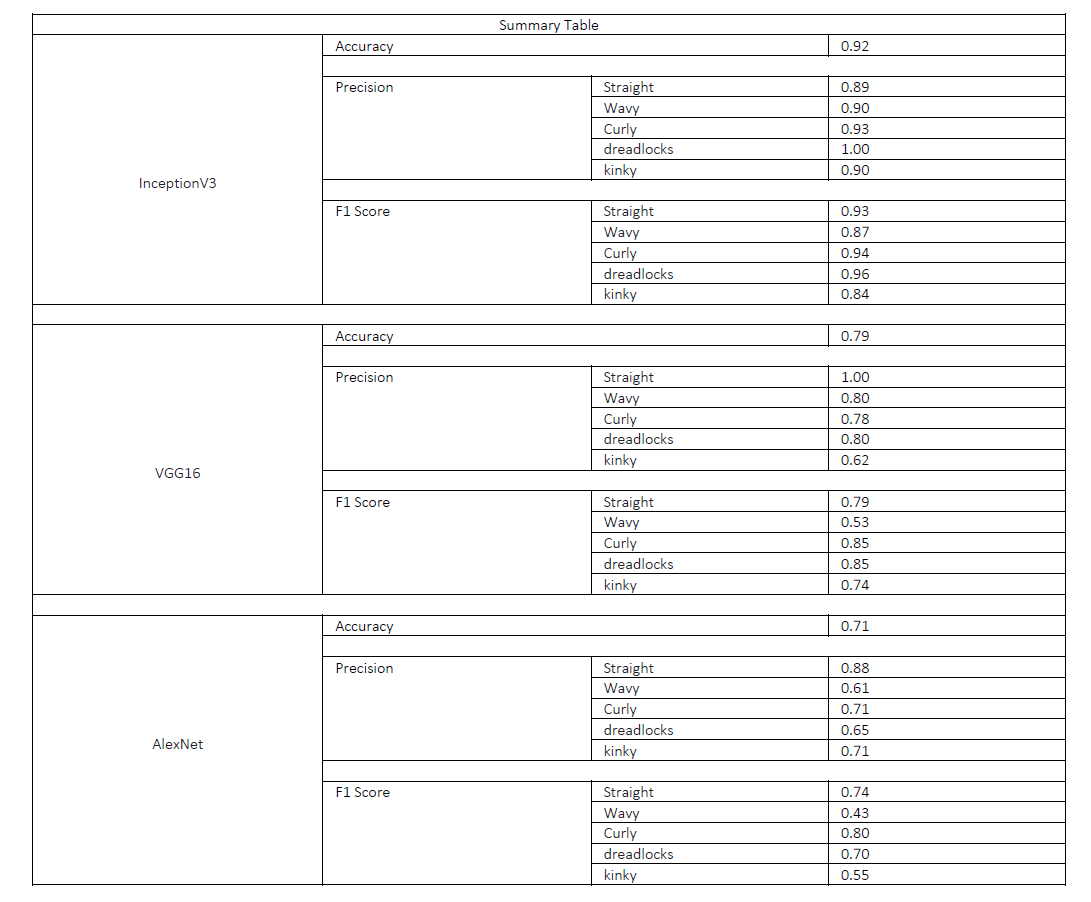